Waveform averaging analysis (individual level)

https://mne.tools/mne-nirs/stable/auto_examples/general/plot_15_waveform.html

## Set up

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import mne
import mne_nirs
import matplotlib.pyplot as plt
import autoreject
from itertools import compress

# Mapping of participants to differential pathlength factors (DPF).
# Adjust as needed for your study/age group.
DPF = {
    'P01': 5.82, 'P02': 5.82, 'P03': 5.73, 'P04': 5.76,
    'P05': 5.76, 'P06': 5.82, 'P07': 5.76, 'P08': 5.79,
    'P09': 5.76, 'P10': 6.00, 'P11': 5.91, 'P12': 5.94,
    'P13': 5.88, 'P14': 5.79, 'P15': 6.20, 'P16': 5.73,
    'P17': 5.94,
}

participant_id = 'P09'

## Load raw data

In [2]:
# Load MNE Raw file (previously exported and converted from OxySoft).
fname = f'data/mne_raw/{participant_id}.fif'
raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)

# Inspect raw data info
print(raw.info)

Opening raw data file data/mne_raw/P09.fif...
    Range : 0 ... 152426 =      0.000 ...  3048.520 secs
Ready.
Reading 0 ... 152426  =      0.000 ...  3048.520 secs...
<Info | 11 non-empty values
 bads: []
 ch_names: S1_D1 hbr, S1_D1 hbo, S2_D1 hbr, S2_D1 hbo, S3_D1 hbr, S3_D1 ...
 chs: 27 Deoxyhemoglobin, 27 Oxyhemoglobin
 custom_ref_applied: False
 dig: 25 items (3 Cardinal, 22 EEG)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 25.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 54
 projs: []
 sfreq: 50.0 Hz
 subject_info: <subject_info | his_id: P09>
>


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_14765/2683878835.py:3: RuntimeWarning: This filename (data/mne_raw/P09.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fname=fname, preload=True, verbose=True)


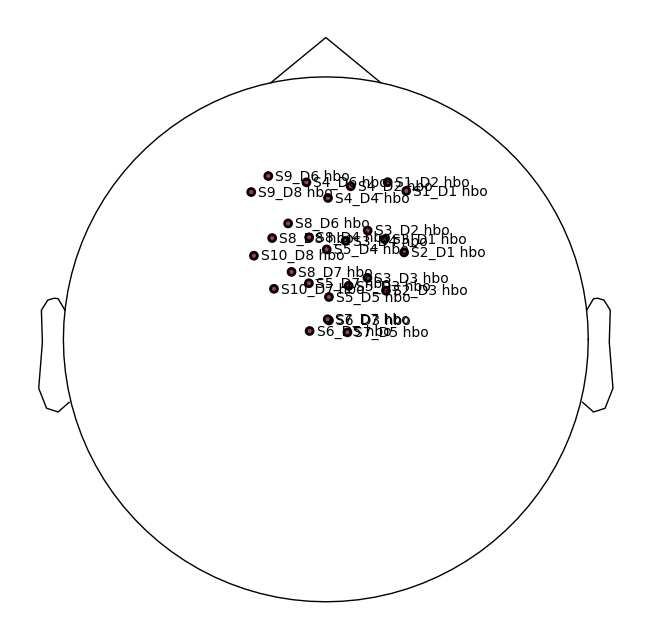

Using matplotlib as 2D backend.


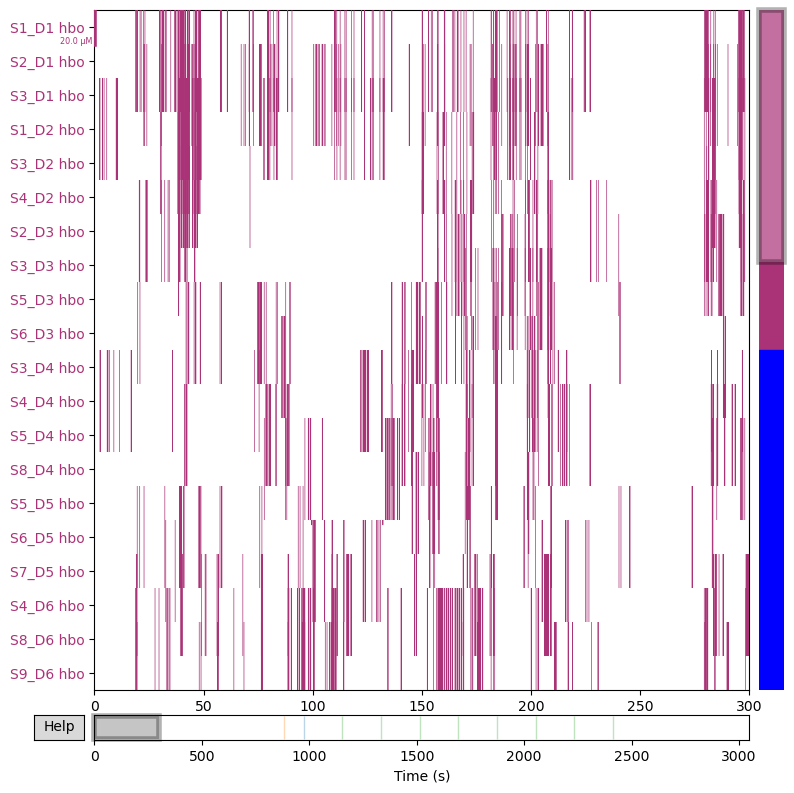

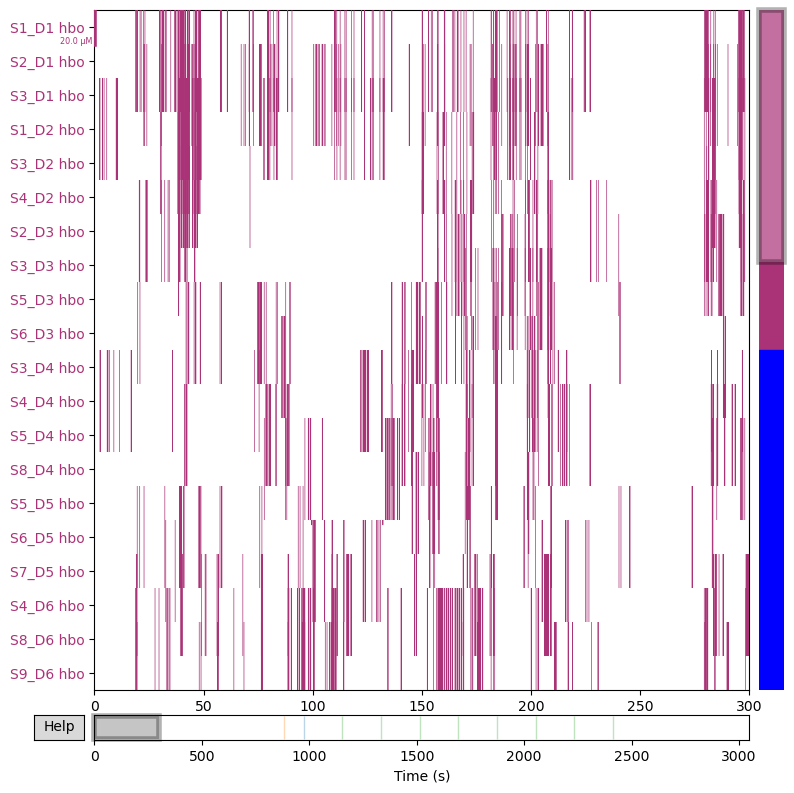

In [3]:
# If desired, you can plot the sensor layout or the raw signals
raw.plot_sensors(show_names=True)
raw.plot(duration=300)

## Load and prepare annotations

In [4]:
# We have a CSV file with self-report data for each participant, e.g. valence ratings.

# row 1 = on-ride
# row 2 = post-ride
# row 3 = route (estimated from footage)

self_reports_csv = pd.read_csv(f'data/self-reports/{participant_id}.csv', header=None)
self_reports = self_reports_csv.values


In [5]:
print("Original annotations:")
print(raw.annotations)

Original annotations:
<Annotations | 10 segments: baseline ends/cycling starts (1), baseline ...>


In [6]:
# Rename annotations according to on-ride self-reports

original_annotations = raw.annotations.copy()

# Make sure the number of prompt annotations in the data matches the number of prompts in csv
# number_of_prompt_annotations = 0
# for i in range(len(original_annotations)):
#     if original_annotations[i]['description'] == 'prompt':
#         number_of_prompt_annotations += 1
# assert number_of_prompt_annotations == len(self_reports[0])

# Workaround because some data files have 1 non-prompt annotation while some have 2
number_of_baseline_annotations = 0
for i in range(len(original_annotations)):
    if 'baseline starts' in original_annotations[i].values():
        number_of_baseline_annotations += 1
    elif 'baseline ends/cycling starts' in original_annotations[i].values():
        number_of_baseline_annotations += 1
    if number_of_baseline_annotations == 2:
        break
if number_of_baseline_annotations == 1:
    onset = original_annotations[1:].onset.copy() - 180  # onset
    duration = np.array([180] * len(original_annotations[1:]))
    description = self_reports[0].copy()
    description = np.char.add('sr', description.astype(str))
elif number_of_baseline_annotations == 2:
    onset = original_annotations[2:].onset.copy() - 180  # onset
    duration = np.array([180] * len(original_annotations[2:]))
    description = self_reports[0].copy()
    description = np.char.add('sr', description.astype(str))

# Add baseline
if raw.annotations[raw.annotations.description == 'baseline ends/cycling starts'].onset[0] > 90:
    onset = np.insert(onset, 0,
                      raw.annotations[raw.annotations.description == 'baseline ends/cycling starts'].onset[0] - 90)
    duration = np.insert(duration, 0, 90)
else:
    onset = np.insert(onset, 0, 0)
    duration = np.insert(duration, 0,
                         raw.annotations[raw.annotations.description == 'baseline ends/cycling starts'].onset[0])

# Workaround for 'baseline' getting truncated to 'bas'
description = description.astype('object')
description = np.insert(description, 0, 'baseline')


print(onset)
print(duration)
print(description)
print(len(onset))
print(len(duration))
print(len(description))

raw.set_annotations(
    annotations=mne.Annotations(
        onset=onset, duration=duration, description=description)

)

[ 884.119995  974.119995 1154.119995 1334.119995 1514.119995 1694.119995
 1874.120117 2054.120117 2234.120117]
[ 90 180 180 180 180 180 180 180 180]
['baseline' 'sr2' 'sr2' 'sr3' 'sr2' 'sr3' 'sr2' 'sr3' 'sr2']
9
9
9


<Raw | P09.fif, 54 x 152427 (3048.5 s), ~62.9 MiB, data loaded>

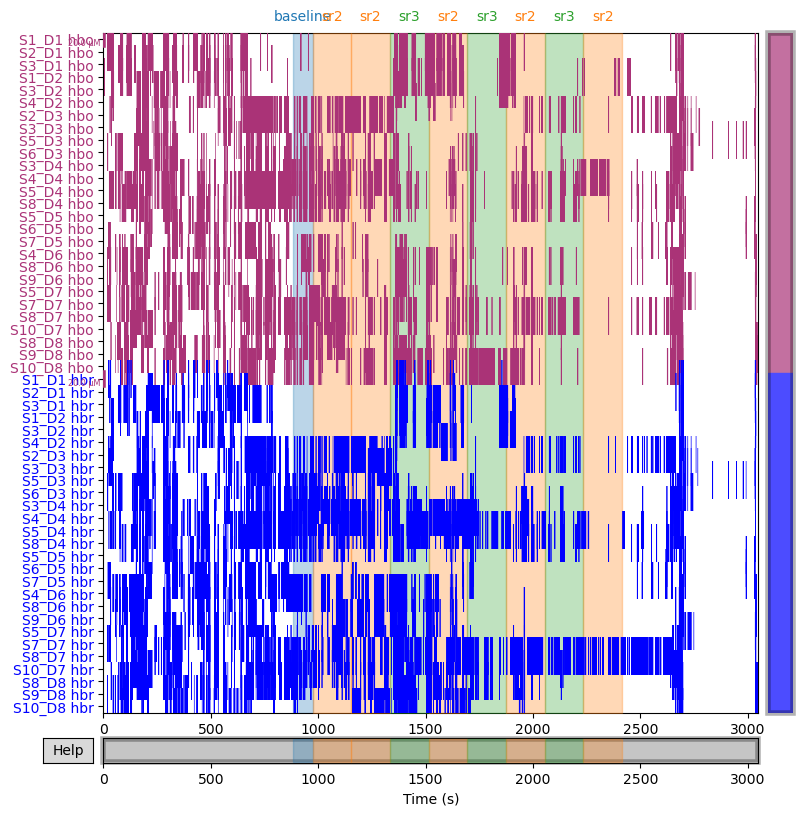

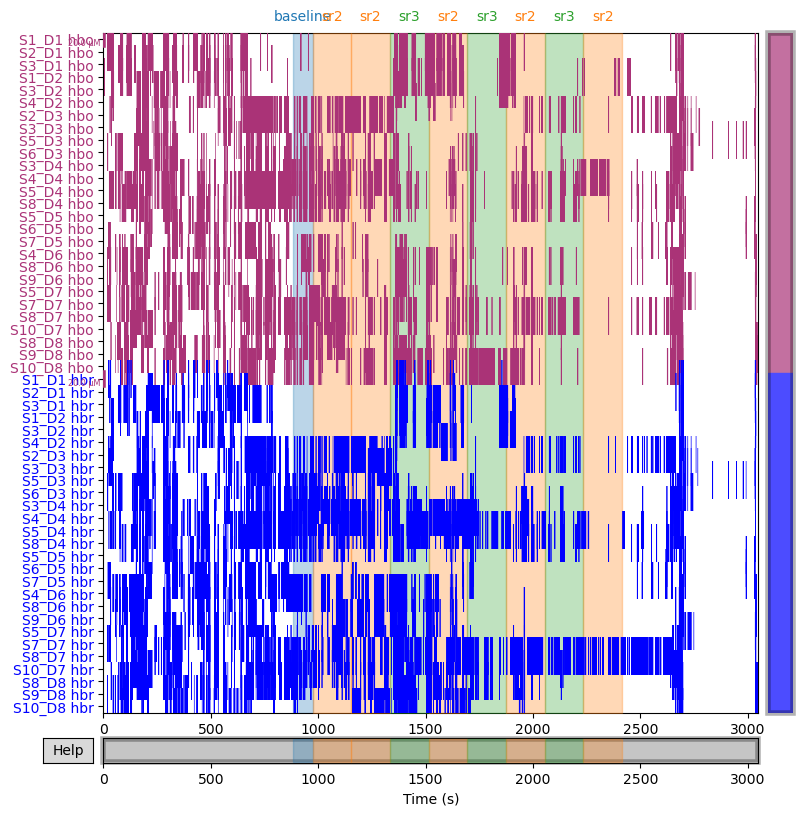

In [7]:
# Plot raw data
duration = len(raw) / raw.info['sfreq']
raw.plot(n_channels=len(raw.ch_names), duration=duration, show_scrollbars=True)


In [8]:
# raw.plot(duration=duration)

## Fix channel type names

In [9]:
raw.info['ch_names']

['S1_D1 hbr',
 'S1_D1 hbo',
 'S2_D1 hbr',
 'S2_D1 hbo',
 'S3_D1 hbr',
 'S3_D1 hbo',
 'S1_D2 hbr',
 'S1_D2 hbo',
 'S3_D2 hbr',
 'S3_D2 hbo',
 'S4_D2 hbr',
 'S4_D2 hbo',
 'S2_D3 hbr',
 'S2_D3 hbo',
 'S3_D3 hbr',
 'S3_D3 hbo',
 'S5_D3 hbr',
 'S5_D3 hbo',
 'S6_D3 hbr',
 'S6_D3 hbo',
 'S3_D4 hbr',
 'S3_D4 hbo',
 'S4_D4 hbr',
 'S4_D4 hbo',
 'S5_D4 hbr',
 'S5_D4 hbo',
 'S8_D4 hbr',
 'S8_D4 hbo',
 'S5_D5 hbr',
 'S5_D5 hbo',
 'S6_D5 hbr',
 'S6_D5 hbo',
 'S7_D5 hbr',
 'S7_D5 hbo',
 'S4_D6 hbr',
 'S4_D6 hbo',
 'S8_D6 hbr',
 'S8_D6 hbo',
 'S9_D6 hbr',
 'S9_D6 hbo',
 'S5_D7 hbr',
 'S5_D7 hbo',
 'S7_D7 hbr',
 'S7_D7 hbo',
 'S8_D7 hbr',
 'S8_D7 hbo',
 'S10_D7 hbr',
 'S10_D7 hbo',
 'S8_D8 hbr',
 'S8_D8 hbo',
 'S9_D8 hbr',
 'S9_D8 hbo',
 'S10_D8 hbr',
 'S10_D8 hbo']

In [10]:
# The raw data sometimes has mislabeled or inconsistent channel names from OxySoft.
# Below, we map them to a consistent pattern (Sx_Dy wavelength).

rename_channels_mapping = {
    'S1_D1 hbr': 'S1_D1 760',
    'S1_D1 hbo': 'S1_D1 850',
    'S2_D1 hbr': 'S2_D1 760',
    'S2_D1 hbo': 'S2_D1 850',
    'S3_D1 hbr': 'S3_D1 760',
    'S3_D1 hbo': 'S3_D1 850',
    'S1_D2 hbr': 'S1_D2 760',
    'S1_D2 hbo': 'S1_D2 850',
    'S3_D2 hbr': 'S3_D2 760',
    'S3_D2 hbo': 'S3_D2 850',
    'S4_D2 hbr': 'S4_D2 760',
    'S4_D2 hbo': 'S4_D2 850',
    'S2_D3 hbr': 'S2_D3 760',
    'S2_D3 hbo': 'S2_D3 850',
    'S3_D3 hbr': 'S3_D3 760',
    'S3_D3 hbo': 'S3_D3 850',
    'S5_D3 hbr': 'S5_D3 760',
    'S5_D3 hbo': 'S5_D3 850',
    'S6_D3 hbr': 'S6_D3 760',
    'S6_D3 hbo': 'S6_D3 850',
    'S3_D4 hbr': 'S3_D4 760',
    'S3_D4 hbo': 'S3_D4 850',
    'S4_D4 hbr': 'S4_D4 760',
    'S4_D4 hbo': 'S4_D4 850',
    'S5_D4 hbr': 'S5_D4 760',
    'S5_D4 hbo': 'S5_D4 850',
    'S8_D4 hbr': 'S8_D4 760',
    'S8_D4 hbo': 'S8_D4 850',
    'S5_D5 hbr': 'S5_D5 760',
    'S5_D5 hbo': 'S5_D5 850',
    'S6_D5 hbr': 'S6_D5 760',
    'S6_D5 hbo': 'S6_D5 850',
    'S7_D5 hbr': 'S7_D5 760',
    'S7_D5 hbo': 'S7_D5 850',
    'S4_D6 hbr': 'S4_D6 760',
    'S4_D6 hbo': 'S4_D6 850',
    'S8_D6 hbr': 'S8_D6 760',
    'S8_D6 hbo': 'S8_D6 850',
    'S9_D6 hbr': 'S9_D6 760',
    'S9_D6 hbo': 'S9_D6 850',
    'S5_D7 hbr': 'S5_D7 760',
    'S5_D7 hbo': 'S5_D7 850',
    'S7_D7 hbr': 'S7_D7 760',
    'S7_D7 hbo': 'S7_D7 850',
    'S8_D7 hbr': 'S8_D7 760',
    'S8_D7 hbo': 'S8_D7 850',
    'S10_D7 hbr': 'S10_D7 760',
    'S10_D7 hbo': 'S10_D7 850',
    'S8_D8 hbr': 'S8_D8 760',
    'S8_D8 hbo': 'S8_D8 850',
    'S9_D8 hbr': 'S9_D8 760',
    'S9_D8 hbo': 'S9_D8 850',
    'S10_D8 hbr': 'S10_D8 760',
    'S10_D8 hbo': 'S10_D8 850',
}

raw.rename_channels(rename_channels_mapping)

<Raw | P09.fif, 54 x 152427 (3048.5 s), ~62.9 MiB, data loaded>

In [11]:
# Set all channel type to fnirs_od (optical density)
ch_names = [
    'S1_D1 760',
    'S1_D1 850',
    'S2_D1 760',
    'S2_D1 850',
    'S3_D1 760',
    'S3_D1 850',
    'S1_D2 760',
    'S1_D2 850',
    'S3_D2 760',
    'S3_D2 850',
    'S4_D2 760',
    'S4_D2 850',
    'S2_D3 760',
    'S2_D3 850',
    'S3_D3 760',
    'S3_D3 850',
    'S5_D3 760',
    'S5_D3 850',
    'S6_D3 760',
    'S6_D3 850',
    'S3_D4 760',
    'S3_D4 850',
    'S4_D4 760',
    'S4_D4 850',
    'S5_D4 760',
    'S5_D4 850',
    'S8_D4 760',
    'S8_D4 850',
    'S5_D5 760',
    'S5_D5 850',
    'S6_D5 760',
    'S6_D5 850',
    'S7_D5 760',
    'S7_D5 850',
    'S4_D6 760',
    'S4_D6 850',
    'S8_D6 760',
    'S8_D6 850',
    'S9_D6 760',
    'S9_D6 850',
    'S5_D7 760',
    'S5_D7 850',
    'S7_D7 760',
    'S7_D7 850',
    'S8_D7 760',
    'S8_D7 850',
    'S10_D7 760',
    'S10_D7 850',
    'S8_D8 760',
    'S8_D8 850',
    'S9_D8 760',
    'S9_D8 850',
    'S10_D8 760',
    'S10_D8 850',
]
ch_types = [
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
    'fnirs_od',
]

raw.set_channel_types(dict(zip(ch_names, ch_types)))

/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_14765/328618863.py:115: RuntimeWarning: The unit for channel(s) S10_D7 760, S10_D7 850, S10_D8 760, S10_D8 850, S1_D1 760, S1_D1 850, S1_D2 760, S1_D2 850, S2_D1 760, S2_D1 850, S2_D3 760, S2_D3 850, S3_D1 760, S3_D1 850, S3_D2 760, S3_D2 850, S3_D3 760, S3_D3 850, S3_D4 760, S3_D4 850, S4_D2 760, S4_D2 850, S4_D4 760, S4_D4 850, S4_D6 760, S4_D6 850, S5_D3 760, S5_D3 850, S5_D4 760, S5_D4 850, S5_D5 760, S5_D5 850, S5_D7 760, S5_D7 850, S6_D3 760, S6_D3 850, S6_D5 760, S6_D5 850, S7_D5 760, S7_D5 850, S7_D7 760, S7_D7 850, S8_D4 760, S8_D4 850, S8_D6 760, S8_D6 850, S8_D7 760, S8_D7 850, S8_D8 760, S8_D8 850, S9_D6 760, S9_D6 850, S9_D8 760, S9_D8 850 has changed from M to NA.
  raw.set_channel_types(dict(zip(ch_names, ch_types)))


<Raw | P09.fif, 54 x 152427 (3048.5 s), ~62.9 MiB, data loaded>

In [12]:
raw.info['chs'][1]

{'scanno': 2,
 'logno': 2,
 'kind': 1100 (FIFFV_FNIRS_CH),
 'range': 1.0,
 'cal': 1.0,
 'coil_type': 303 (FIFFV_COIL_FNIRS_OD),
 'loc': array([0.0391767 , 0.07229549, 0.05905945, 0.03767842, 0.08421859,
        0.04908523, 0.04067497, 0.0603724 , 0.06903367,        nan,
               nan,        nan]),
 'unit': -1 (FIFF_UNIT_NONE),
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'ch_name': 'S1_D1 850',
 'coord_frame': 4 (FIFFV_COORD_HEAD)}

In [13]:
# Workaround for setting wavelengths
for i in range(len(raw.info['chs'])):
    if raw.info['chs'][i]['ch_name'].endswith('760'):
        raw.info['chs'][i]['loc'][9] = 7.60000000e+02
    elif raw.info['chs'][i]['ch_name'].endswith('850'):
        raw.info['chs'][i]['loc'][9] = 8.50000000e+02



## Evaluating data quality

[Text(0.5, 0, 'Scalp Coupling Index'), Text(0, 0.5, 'Count'), (0.0, 1.0)]

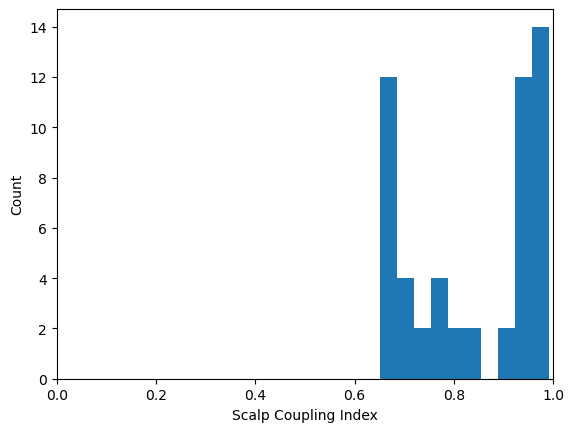

In [14]:
# https://mne.tools/mne-nirs/stable/auto_examples/general/plot_22_quality.html#sphx-glr-auto-examples-general-plot-22-quality-py

# Calculate the scalp coupling index (SCI) to identify potentially bad channels
sci = mne.preprocessing.nirs.scalp_coupling_index(raw)
fig, ax = plt.subplots()
ax.hist(sci)
ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])

In [15]:
# Mark channels with SCI < 0.7 as "bad"
raw.info['bads'] = list(compress(raw.ch_names, sci < 0.7))
print(raw.info['bads'])


['S1_D1 760', 'S1_D1 850', 'S1_D2 760', 'S1_D2 850', 'S8_D4 760', 'S8_D4 850', 'S8_D6 760', 'S8_D6 850', 'S7_D7 760', 'S7_D7 850', 'S9_D8 760', 'S9_D8 850']


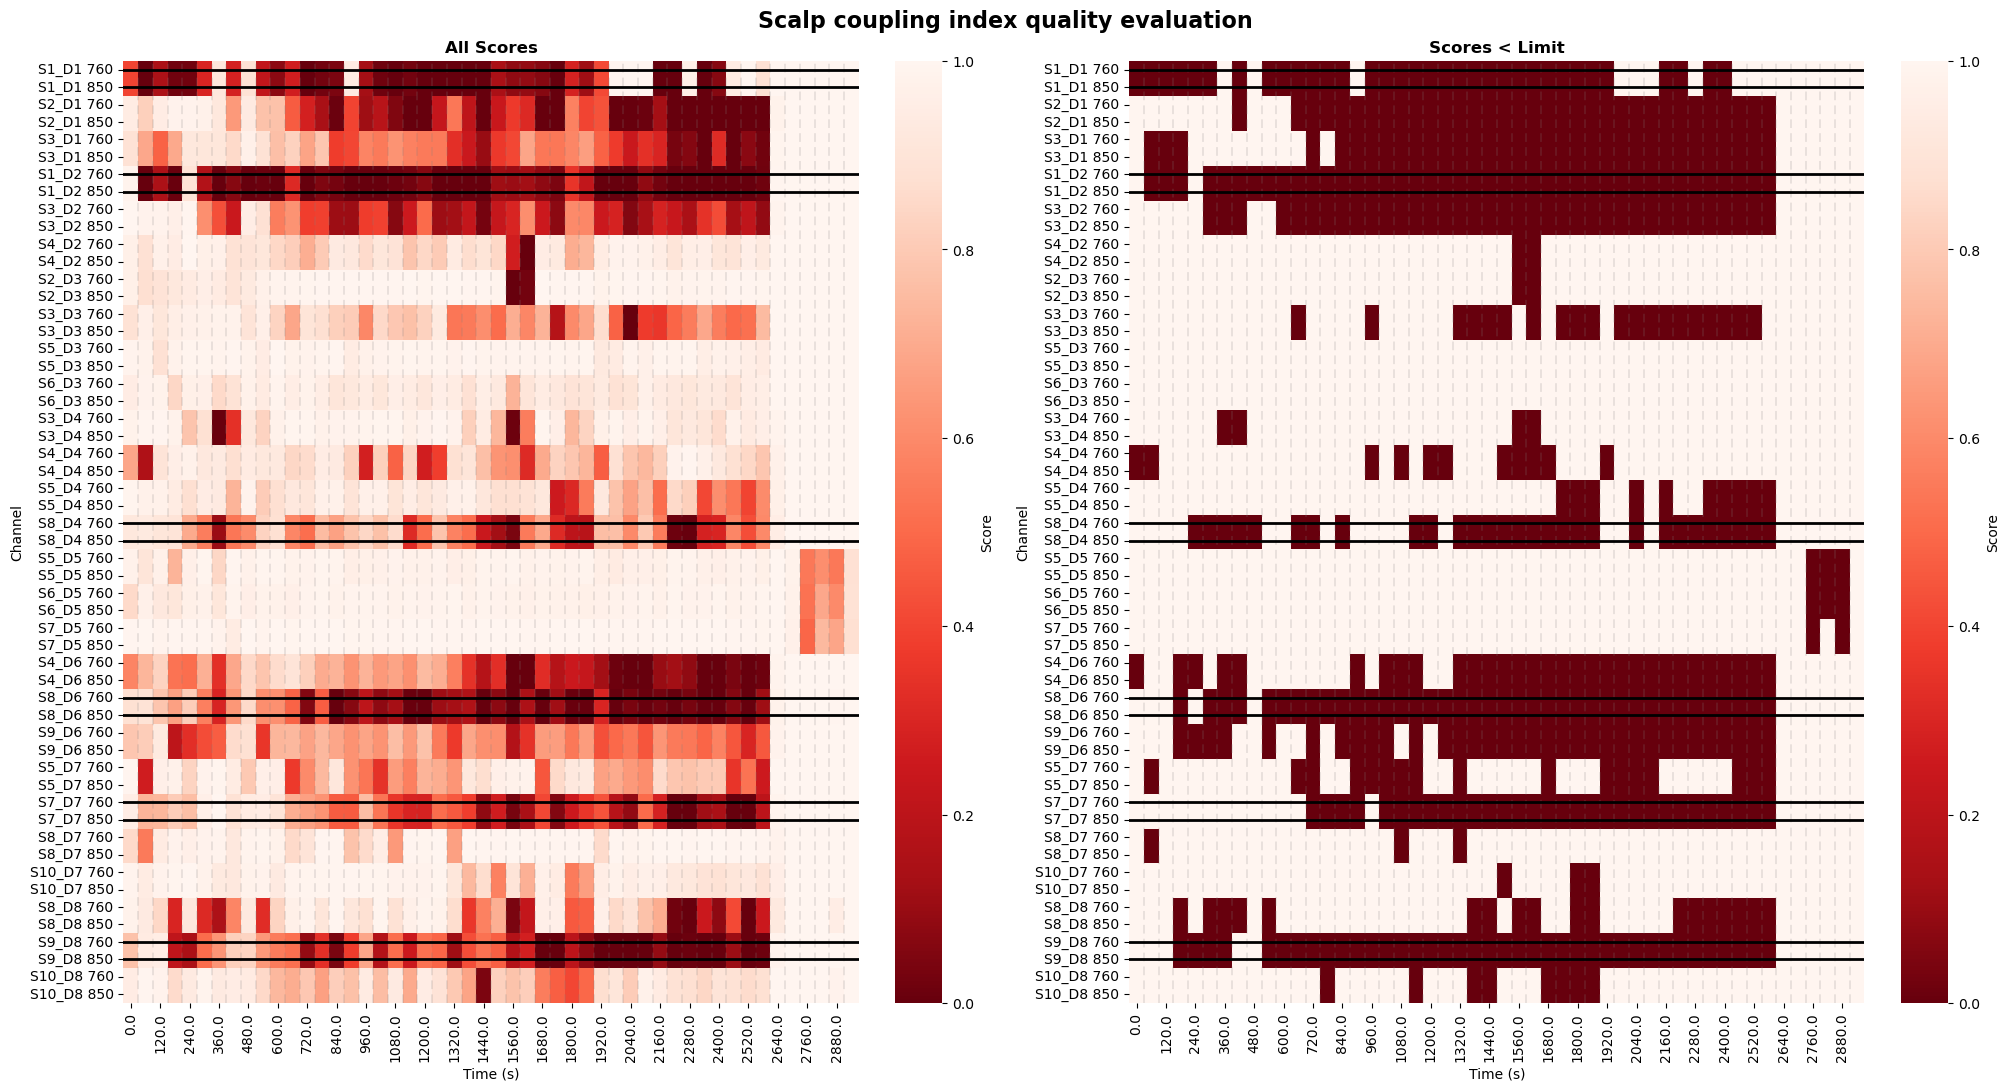

In [16]:
# Evaluate SCI in a moving window to see how coupling changes over time
_, scores, times = mne_nirs.preprocessing.scalp_coupling_index_windowed(raw, time_window=60)
mne_nirs.visualisation.plot_timechannel_quality_metric(raw, scores, times, threshold=0.7,
                                title="Scalp coupling index "
                                      "quality evaluation");

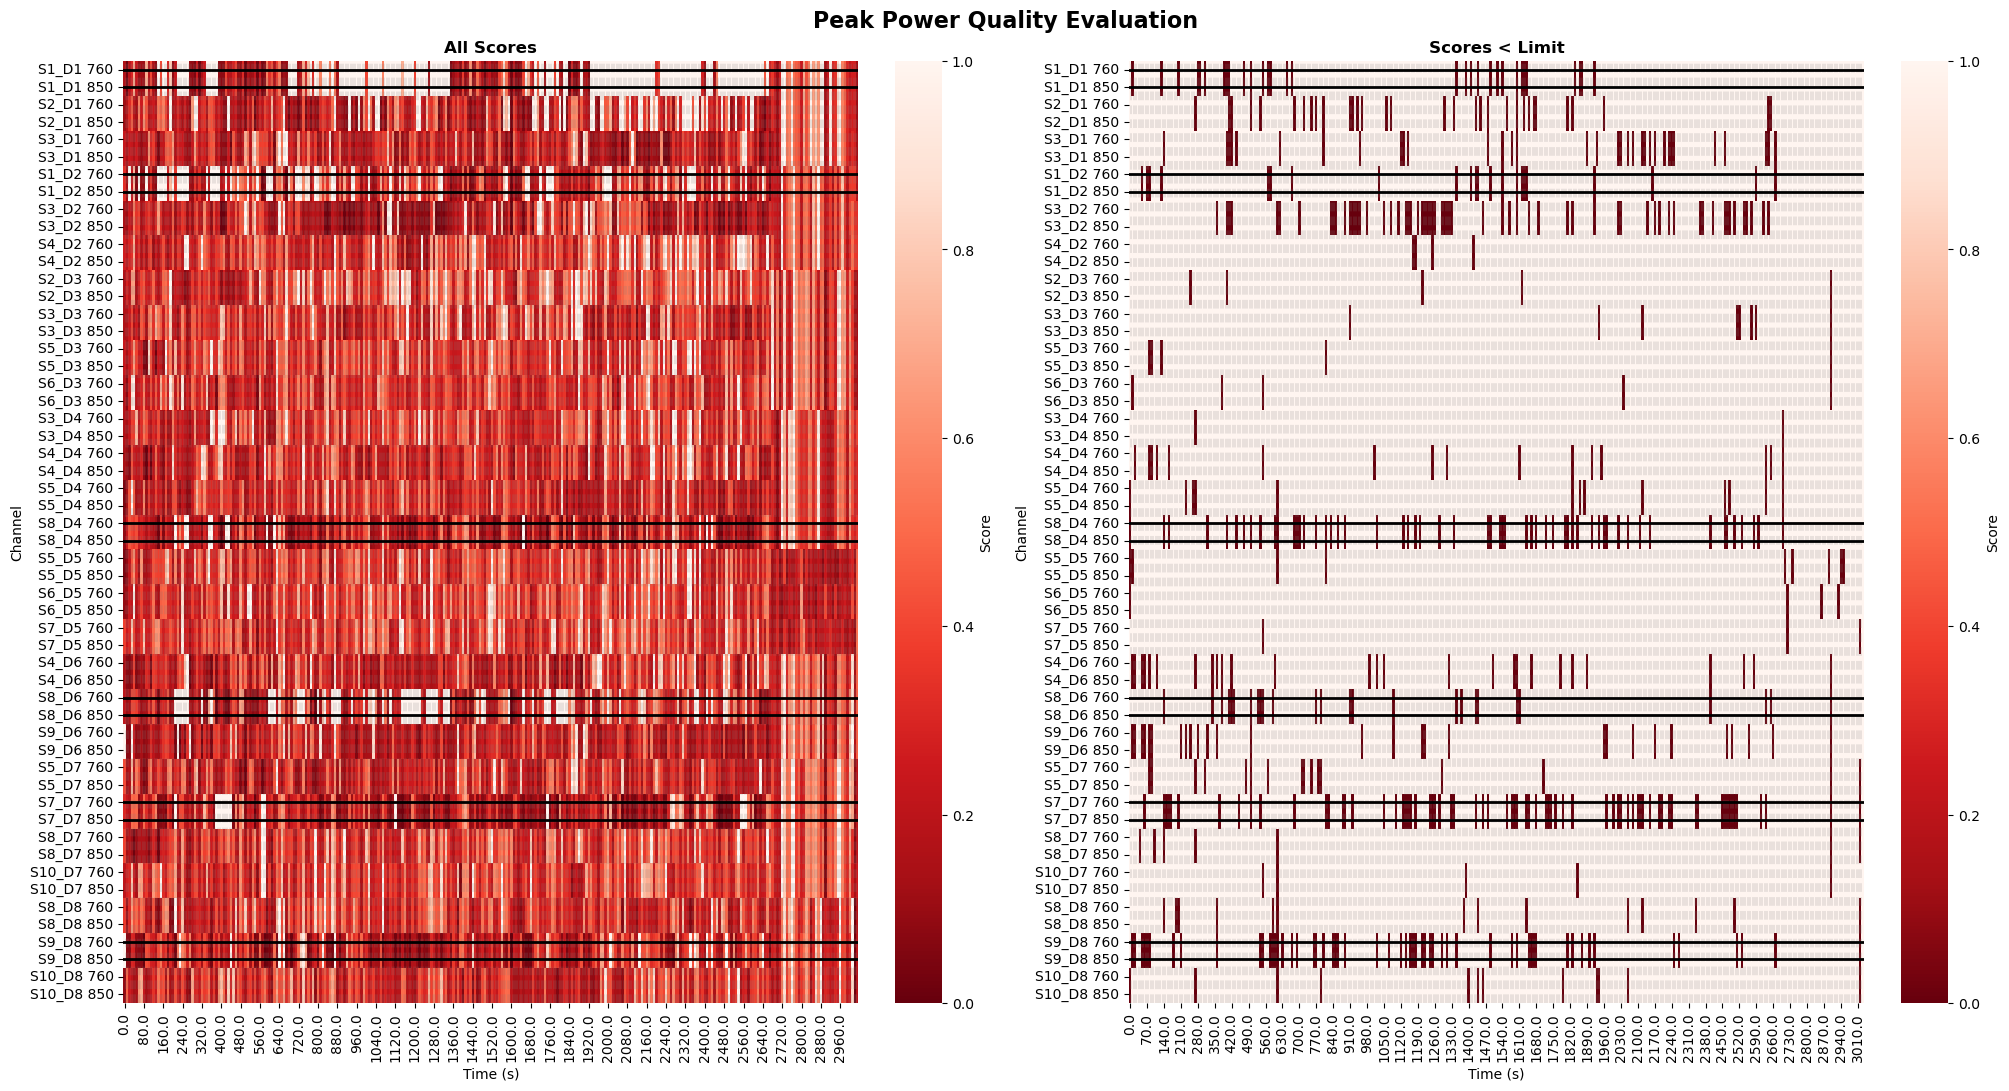

In [17]:
# Evaluate peak power to detect segments with large, spurious peaks
raw, scores, times = mne_nirs.preprocessing.peak_power(raw, time_window=10)
mne_nirs.visualisation.plot_timechannel_quality_metric(raw, scores, times, threshold=0.1,
                                title="Peak Power Quality Evaluation");

In [18]:
# raw.plot(duration=duration)

In [19]:
len(raw.info['bads'])

12

## Artifact repair using TDDR

In [20]:
# Temporal derivative distribution repair

# This approach corrects baseline shift and spike artifacts without
# the need for any user-supplied parameters FishburnEtAl2019.

# https://mne.tools/mne-nirs/stable/auto_examples/general/plot_21_artifacts.html#sphx-glr-auto-examples-general-plot-21-artifacts-py

raw = mne.preprocessing.nirs.temporal_derivative_distribution_repair(raw)

## Converting to haemoglobin concentrations

In [21]:
# If data were originally in raw intensity format, we would first convert to optical
# density with: raw_od = mne.preprocessing.nirs.optical_density(raw)
# Some systems export data already in OD, so you may skip that step as needed.

# Apply the modified Beer–Lambert law to convert OD to haemoglobin.
# The pathlength factor can be set or derived from a dictionary (DPF).
# Adjust as necessary for your age group (e.g., DPF[participant_id]).


# raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw, ppf=DPF[participant_id])
# raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw, ppf=0.1)
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(raw, ppf=DPF[participant_id]/50)


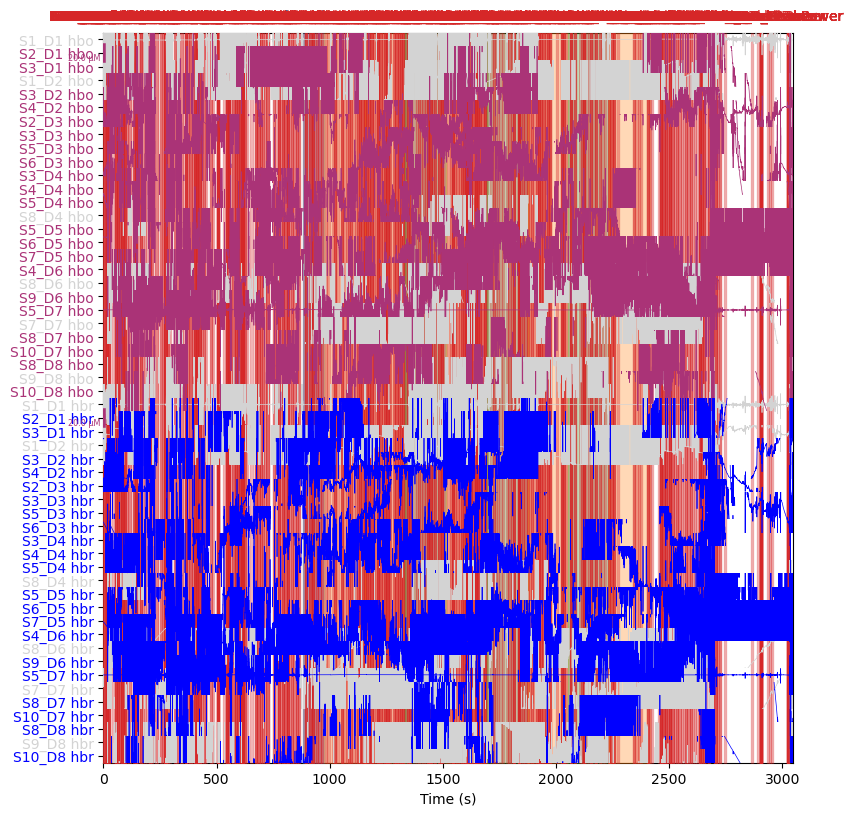

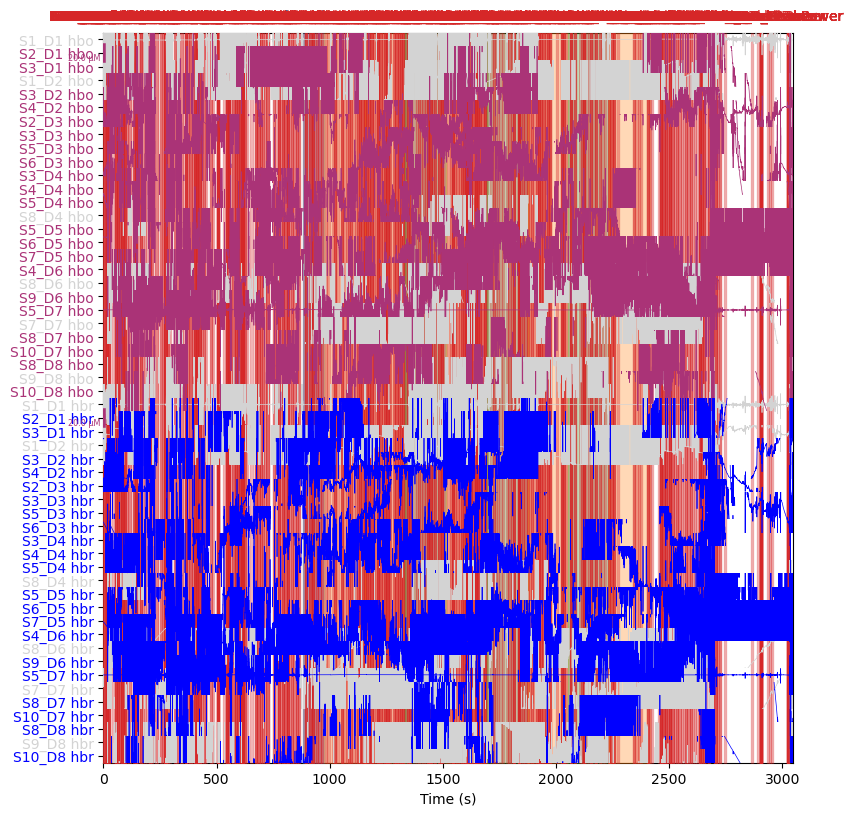

In [22]:
raw_haemo.plot(n_channels=len(raw_haemo.ch_names),
               duration=duration, show_scrollbars=False)

## Preprocessing: filtering

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 8251 samples (165.020 s)

Setting 116000 of 152427 (76.10%) samples to NaN, retaining 36427 (23.90%) samples.
Effective window size : 40.960 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.
Plotting power spectral density (dB=True).
Setting 116000 of 152427 (76.10%) samples to NaN, retaining 36427 (23.90%) samples.
Effective window size : 40.960 (s)
At least one good data span i

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 500, using nperseg = 500
  return _func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 500, using nperseg = 500
  return _func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 500, using nperseg = 500
  return _func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 500, using nperseg = 500
  return _func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/e

Plotting power spectral density (dB=True).


/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 500, using nperseg = 500
  return _func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 500, using nperseg = 500
  return _func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 1000, using nperseg = 1000
  return _func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/mne/time_frequency/psd.py:257: UserWarning: nperseg = 2048 is greater than input length  = 500, using nperseg = 500
  return _func(*args, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/jcmr/lib/python3.13/site-packages/mne/time_frequency/ps

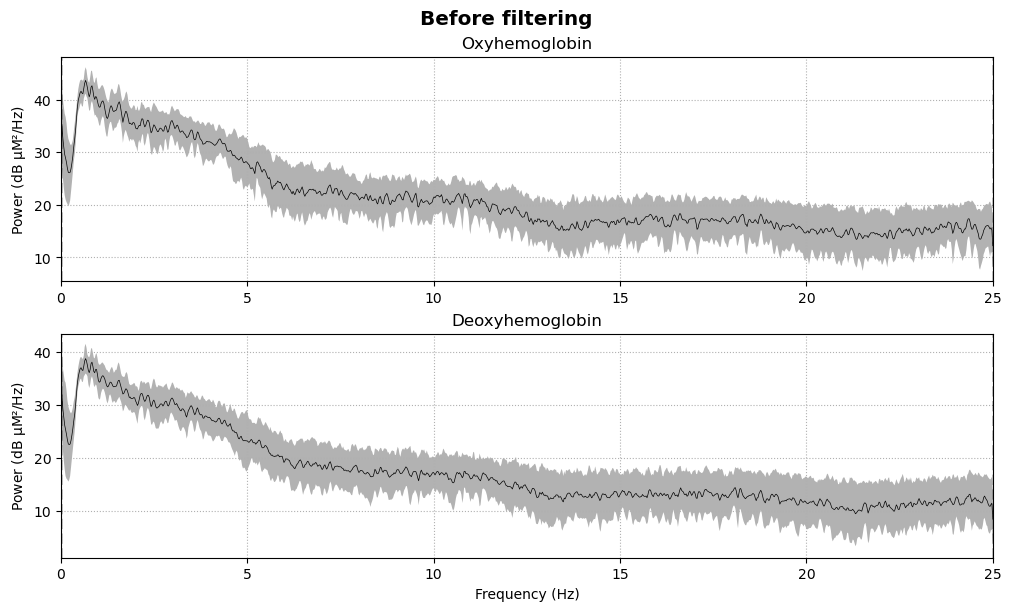

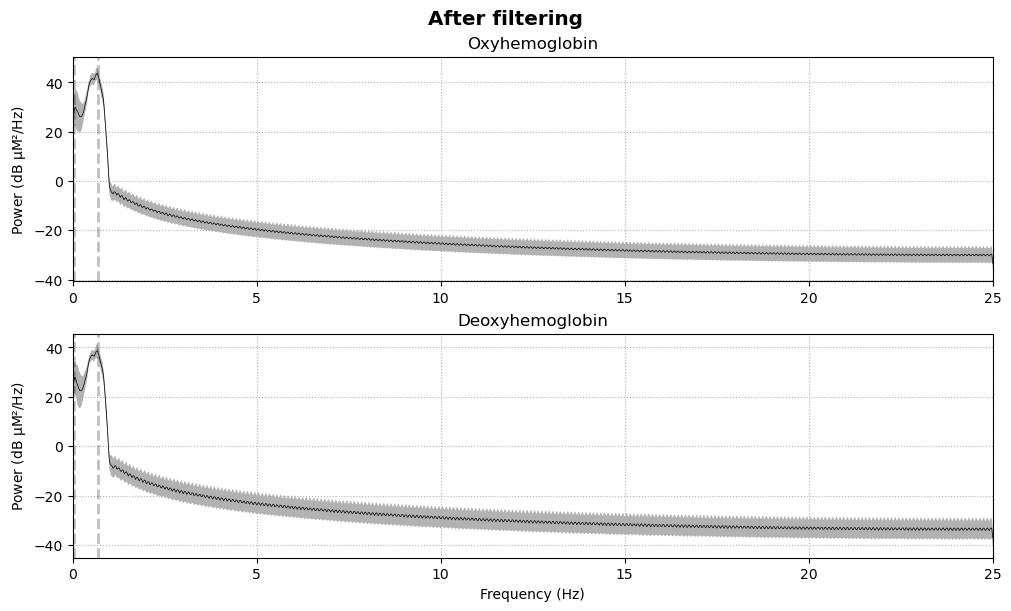

In [23]:
%matplotlib inline

# Removing heart rate from signal

# https://mne.tools/stable/auto_tutorials/preprocessing/70_fnirs_processing.html#sphx-glr-auto-tutorials-preprocessing-70-fnirs-processing-py

# Make a copy for PSD comparison before filtering
raw_haemo_unfiltered = raw_haemo.copy()

# Filter out heart rate and slow drifts: e.g., bandpass 0.05 - 0.7 Hz
raw_haemo.filter(0.05, 0.7, h_trans_bandwidth=0.2, l_trans_bandwidth=0.02)
for when, _raw in dict(Before=raw_haemo_unfiltered, After=raw_haemo).items():
    fig = _raw.compute_psd().plot(average=True, picks="data", exclude="bads");
    fig.suptitle(f"{when} filtering", weight="bold", size="x-large");
    fig.subplots_adjust(top=0.88);


## Negative correlation enhancement

In [24]:
# Enhances the expected negative correlation between HbO and HbR.
# https://mne.tools/mne-nirs/stable/auto_examples/general/plot_20_enhance.html

raw_haemo = mne_nirs.signal_enhancement.enhance_negative_correlation(raw_haemo)

In [25]:
# raw_haemo.plot(duration=duration)

## Waveform averaging analysing (epoching)

In [26]:
EPOCH_DURATION = 15

In [27]:
# Create events from annotations with chunk_duration=EPOCH_DURATION,
# ignoring the "baseline" annotation in the event_id.
events, event_id = mne.events_from_annotations(
    raw_haemo, chunk_duration=EPOCH_DURATION, verbose=True)

del event_id['baseline']
print("Event dictionary (excluding baseline):", event_id)


Used Annotations descriptions: [np.str_('baseline'), np.str_('sr2'), np.str_('sr3')]
Event dictionary (excluding baseline): {np.str_('sr2'): 2, np.str_('sr3'): 3}


/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_14765/2858621041.py:2: RuntimeWarning: event 1 missing from event_id will be ignored
  fig_events = mne.viz.plot_events(


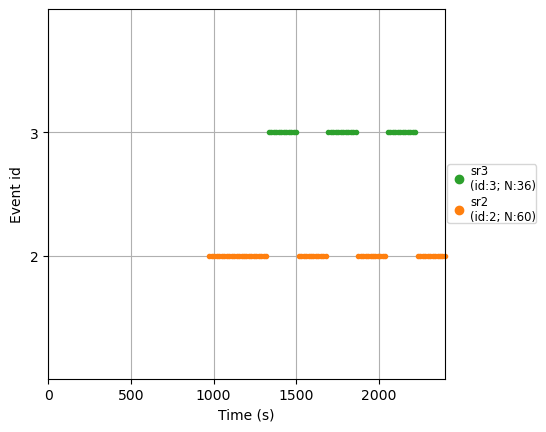

/var/folders/8h/_n6ts5_10fqd7rn3b5llj7d80000gn/T/ipykernel_14765/2858621041.py:5: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig_events.subplots_adjust(right=0.7)


In [28]:
# Visualise the events
fig_events = mne.viz.plot_events(
    events, event_id=event_id, sfreq=raw_haemo.info['sfreq']
)
fig_events.subplots_adjust(right=0.7)
plt.show()

In [29]:
reject_criteria = dict(hbo=80e-6)

# Define epoching parameters
tmin, tmax = 0, EPOCH_DURATION
baseline = (0, EPOCH_DURATION)

# Perform epoching
epochs = mne.Epochs(raw_haemo, events, event_id=event_id,
                    tmin=tmin, tmax=tmax, baseline=baseline, preload=True,
                    reject=None, reject_by_annotation=True)

Not setting metadata
96 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 96 events and 751 original time points ...
92 bad epochs dropped


In [30]:
epochs

<Epochs | 4 events (all good), 0 – 15 s (baseline 0 – 15 s), ~1.3 MiB, data loaded,
 np.str_('sr2'): 4
 np.str_('sr3'): 0>

## Inspect epochs

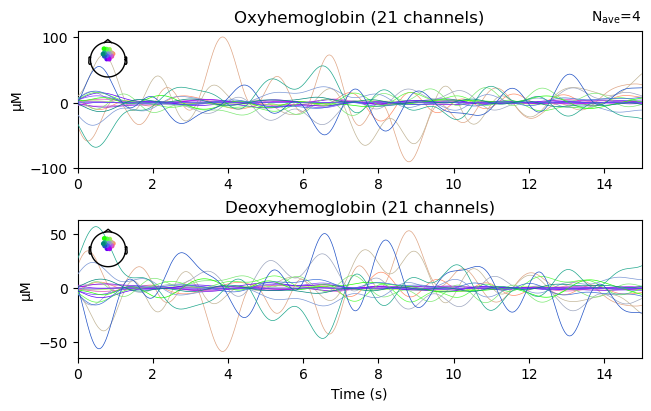

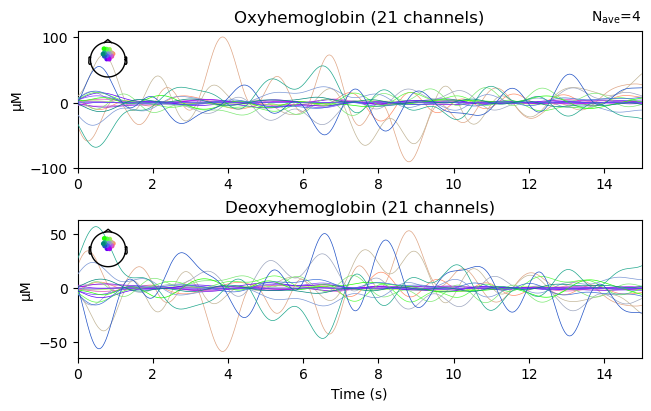

In [31]:
# epochs['baseline'].average().plot()
# epochs['sr1'].average().plot()
epochs['sr2'].average().plot()
# epochs['sr3'].average().plot()